In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

<img src = "TITLE COVER.png"/>




# Euclidian distance basis for similarity on PH recorded eathquakes as a predictor of earthquake category in the Richter Scale

## Executive Summary
***
In this report, we focus on the earthquake prediction using a data-drive approach, focusing on the United States Geographical Survey (USGS) earthquake catalog. Our objective is to show and assess the reliability of using the Euclidean distance as a measure of similarity. The idea is to analyze whether the nearest neighbor earthquakes, determine through  Euclidean distance, tend to share the same category as exemplar. 


By navigating the vast dataset from the USGS, we aim to find patterns and relationships that exist among earthquakes. As we embark on these findings, this will also advance our understanding of the dynamics that govern earthquake categorization on the Richter Scale.

This report not only contribute to the field of earthquake prediction but also highlights the importance and usage of robust data mining and wrangling techniques to extract meaningful insights from seismic data from the available resource.

## Introduction
***
As per Japan International Cooperation Agency (JICA), the Philippines is one of the countries with the highest number of natural disasters in Southeast Asia. The Philippines is also in the “Pacific Ring of Fire” and this makes the country vulnerable to earthquakes and volcanic eruptions. In addition, the geographical location and physical environment of the country affects the high-susceptibility to tsunamis, sea-level rise and among other national disasters. The Philippine Institute of Volcanology and Seismology (PHIVOLCS) also published that around 100-150 earthquakes per year (with magnitude of 4.0 and above) have been felt from year 1600s to early 2000. These earthquake displaces thousands of families each year not to mention the economic impact on the damages of properties of this disaster.

The World Bank data below also indicates that earthquake still affects the lives of thousands of people in this country. The graph below shows that the 1990 Luzon earthquake with a magniute of 7.7 affected more than a million in the area and also the Bohol earthquake in 2013. More recently, on 02 December 2023, a magnitude of 7.2 earthquake strucked the island of Mindanao which even alerted tsunami warnings in the area.

<img src = "key-natural-hazard-stati.png"/>

<b> Richter Scale </b>

In response to these disasters, guidelines and protocol have been put in place to gather, monitor, and predict data to inform the public of these seismic activities.The Richter scale is a logarithmic scale used to measure the magnitude of earthquakes. This is also widely used to communicate the magnitude of earthquakes to the public. In addition, it also provides a standardized and easy to understand measure of the size of the earthquake.

Earthquakes are classified into different categories based on their strength, effects and frequency. A current form of the Richter Scale is shown below:

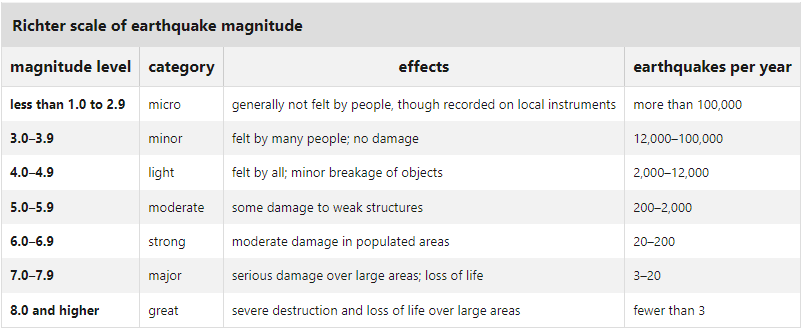

<b> United States Geological Survey (USGS) </b>

The USGS is a US government agency provides reliable data that can be utilized globally which spans across natural resources, natural hazards and overall landscape of the Earth. One of its critical role is to monitor and report on seismic activity and it also operates National Earthquake Information Centre (NEIC), which monitors worldwide natural disasters and provides real-time data which includes location, depth, magnitude and other relevant details.

It has a historical catalog of earthquake events via API. Which contains numeric features from cataloged earthquake events:
- mag - The magnitude for the event
- felt - The total number of felt reports submitted to the DYFI? system.
- cdi - The maximum reported intensity for the event
- mmi - The maximum estimated instrumental intensity for the event
- sig - A number describing how significant the event is. Larger numbers indicate a more significant event.
- rms - The root-mean-square (RMS) travel time residual, in sec, using all weights. This parameter provides a measure of the fit of the observed arrival times to the predicted arrival times for this location. Smaller numbers reflect a better fit of the data. The value is dependent on the accuracy of the velocity model used to compute the earthquake location, the quality weights assigned to the arrival time data, and the procedure used to locate the earthquake.

## Problem Statement
***

With the above, this report seeks to explore if the earthquake category be predicted based from a recent occured earthquake exemplar of a category and its similarity to other Philippine earthquakes in the historical dataset from (2013-2023).


## Data Collection and Methodology
***
<img src = "DCM.png"/>


Raw data is extracted via API endpoint documented in https://earthquake.usgs.gov/fdsnws/event/1/?ref=springboard

In [2]:
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": "2013-01-01",
    "endtime": "2023-12-01",
    "latitude": 12.8797,    # Approximate latitude for the Philippines
    "longitude": 121.7740,  # Approximate longitude for the Philippines
    "maxradiuskm": 1000     # Radius to cover the region around the Philippines
}

# Fetch the data
response = requests.get(url, params=params)
earthquake_data = response.json()
df_earthquakes = pd.json_normalize(earthquake_data['features'])

Add the categories based on the Richter Scale Figure above based on its magnitude

In [3]:
magnitude_bins = [
    0, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, float('inf')
]
magnitude_labels = [
    'micro', 'minor', 'light', 'moderate', 'strong', 'major', 'great'
]

df_earthquakes['magnitude_category'] = pd.cut(
    df_earthquakes['properties.mag'],
    bins=magnitude_bins,
    labels=magnitude_labels,
    right=False
)
df_earthquakes['datetime'] = pd.to_datetime(
    df_earthquakes['properties.time'], unit='ms'
)
df_earthquakes['depth'] = df_earthquakes['geometry.coordinates']\
    .apply(lambda x: x[2])

Display Value counts of categories

In [4]:
df_earthquakes['magnitude_category'].value_counts()

magnitude_category
light       5010
moderate     855
strong        64
major          6
minor          2
micro          0
great          0
Name: count, dtype: int64

Select exemplars per category, since micro and great events have 0 counts they will be excluded 

In [5]:
exemplar_dict = {}

for i in magnitude_labels:
    try:
        exemplar_dict[i] = df_earthquakes[df_earthquakes['magnitude_category'] == i]\
          .sort_values(by='datetime', ascending=False).iloc[0].name
    except:
        continue
print(exemplar_dict)

{'minor': 1015, 'light': 0, 'moderate': 5, 'strong': 19, 'major': 709}


Get all fields that are numeric, fill na's and exclude features. Magnitude is excluded as category was calculated from it and suggests an obvious strong relationship between the numerical and the category it will belong to:

In [6]:
df_features = df_earthquakes._get_numeric_data()
df_features = df_features.fillna(0)
df_features = df_features.drop(
    columns=[
        'properties.mag',
        'properties.time',
        'properties.updated',
        'properties.tsunami',
        'properties.gap',
        'properties.dmin',
        'properties.nst',
        # 'depth',
    ]
)
print(df_features.columns)
# display(df_features.max())
# display(df_features.min())

Index(['properties.felt', 'properties.cdi', 'properties.mmi', 'properties.sig',
       'properties.rms', 'depth'],
      dtype='object')


Normalize features:

In [7]:
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_features)

In [8]:
def get_top_10_similar_from_exemplar(
    exemplar_index, df_norm, df
):
    exemplar = df_norm[exemplar_index]
    # print(df.iloc[exemplar_index])
    new_df_norm = np.delete(df_norm, exemplar_index, axis=0)

    similarity = np.linalg.norm(
        new_df_norm - exemplar, ord=2, axis=1
    )
    df = df.drop(exemplar_index)
    df['similarity'] = similarity
    similar_earthquakes = df.sort_values(
        by='similarity',
        ascending=True
    ).iloc[1:].head(10)
    return similar_earthquakes

Display top 10 similar earthquakes to category exemplar and compute percentage accuracy of prediction that the similar earthquakes are the same category

In [9]:
labels = list(exemplar_dict.keys())

for category, value in exemplar_dict.items():
    print(category)
    print("exemplar:") 
    display(pd.DataFrame(df_earthquakes[['id', 'magnitude_category', 'datetime']].iloc[value]).T)
    x = get_top_10_similar_from_exemplar(value, df_normalized, df_earthquakes)
    display_df = x[['id', 'magnitude_category']]
    display(display_df)
    acc_pred = display_df['magnitude_category'].eq(category).astype(int).sum()/len(display_df)
    print(f"{acc_pred*100:.2f}")
    print("\n")

minor
exemplar:


,id,magnitude_category,datetime
1015,us7000gx9e,minor,2022-03-21 00:02:09.809000


,id,magnitude_category
3859,us20008lvi,light
1585,us7000e3sq,light
4000,us20007exs,light
2488,us70006f2m,light
1648,us6000dws9,light
420,us7000j62b,light
1623,us6000e39l,light
4683,us10001sa1,light
1639,us6000dwws,light
4257,us20005asi,light


0.00


light
exemplar:


,id,magnitude_category,datetime
0,us7000lg6p,light,2023-11-29 20:41:38.230000


,id,magnitude_category
896,us6000hfln,light
2263,us70007nuz,light
2334,us60007ete,light
3118,us2000j8s9,light
2410,us70006u6t,light
5695,usb000k60h,light
2881,us70003ieq,light
1447,us6000f1xq,light
2341,us60007et6,light
2640,us70005skp,light


100.00


moderate
exemplar:


,id,magnitude_category,datetime
5,us6000lqu5,moderate,2023-11-26 08:24:35.374000


,id,magnitude_category
5548,usb000kiln,moderate
5706,usb000jli4,moderate
1404,us6000f4qs,moderate
2149,us60009czd,moderate
3013,us2000jih8,moderate
4053,us10006nlv,moderate
776,us7000hfpp,moderate
5439,usc000lvk3,moderate
5026,usb000s3cp,moderate
4394,us100048g8,moderate


100.00


strong
exemplar:


,id,magnitude_category,datetime
19,us6000lp12,strong,2023-11-17 08:14:11.870000


,id,magnitude_category
2545,us700061e9,strong
3672,us1000976a,strong
399,us6000jkpr,strong
384,us6000jp76,strong
3752,us10008ls4,major
2574,us6000645n,strong
1434,us6000f48v,major
544,us6000iwds,strong
1996,us6000bgbr,strong
1703,us6000df9r,strong


80.00


major
exemplar:


,id,magnitude_category,datetime
709,us6000i5rd,major,2022-07-27 00:43:26.871000


,id,magnitude_category
3814,us10008fsd,strong
3623,us2000a77i,strong
1456,us6000eyfk,strong
3718,us10008vb2,moderate
3823,us10008ea7,moderate
1783,us6000d2ra,strong
188,us7000k8jz,strong
1317,us7000fen1,moderate
2616,us70005ulm,strong
2922,us70003aj3,strong


0.00




## Results and Discussion
***

The prediction accuracy for minor earthquakes stood at 0%. The model primarily identified earthquakes of lighter magnitudes, overlooking the rarer occurrences of minor and major events. A closer examination of the dataset revealed a scarcity of instances, with only 2 minor and 6 major earthquakes recorded. This scarcity likely contributed to the challenges our model faced in predicting events outside the light earthquake category.

On the other hand, the accuracy of predictions soared to 100% for the light and moderate earthquake categories. This achievement can be attributed to the substantial representation of these categories within the dataset available. With the majority of rows falling into these two groups, our model had an abundance of samples for comparison, resulting in accurate predictions.

Moving on to the strong earthquake category, our model demonstrated an 80% accuracy. While not reaching the perfection observed in the light and moderate categories, this outcome remains commendable. The slight dip in accuracy might be attributed to the comparatively lower sample size for strong earthquakes. Despite this, the model showcased robust predictive capabilities for this category.





## Conclusion
***
From the results, it would appear that the Euclidean distance similarity from a category examplar can be a good predictor that other similar earthquakes would have the same category given significant sample size that exist and if the sample size is not significant the predictor fails.

The model excels in foreseeing light and moderate earthquakes, benefiting from the ample data available in these categories. However, improvements are needed for predicting minor earthquakes, necessitating further refinement and possibly an expanded dataset. Nevertheless, the promising accuracy achieved in the strong earthquake category suggests the potential of our approach when provided with more diverse samples. As we continue to refine our methods, we remain optimistic about the prospects of leveraging Euclidean distance for earthquake prediction in the realm of data mining and wrangling.

## References
***
[1] API Documentation - Earthquake Catalog. USGS Earthquake Website. https://earthquake.usgs.gov/fdsnws/event/1/?ref=springboard

[2] Earthquake Magnitude. Britannica Website. https://www.britannica.com/science/earthquake-geology/Earthquake-magnitude

[3] The Project for Improvement of Equipment for Disaster Risk Management”. JICA Website. https://www2.jica.go.jp/en/evaluation/pdf/2020_1161600_4_f.pdf

[4] Philippines: Seismic Events In April 2017 - Earthquake Catalog. United Nations Office for the Coordination of Humanitarian Affairs. 
https://reliefweb.int/map/philippines/philippines-seismic-events-april-2017#:~:text=The%20Philippines%2C%20which%20lies%20along,year%201600s%20to%20early%202000

[5] Information on Disaster Risk Reducion of the Member Countries. Asian Risk Reduction Center Website.
https://www.adrc.asia/nationinformation.php?NationCode=608&Lang=en#:~:text=Being%20situated%20in%20the%20%E2%80%9CPacific,flashflood%2Fflooding%2C%20and%20drought.ht

[6] Risk > Historical Hazards (Philippines). World Bank Website. https://climateknowledgeportal.worldbank.org/country/philippines/vulnerabilityhttps://climateknowledgeportal.worldbank.org/country/philippines/vulnerability